# **[1] image extractor from video**

비디오로 부터 이미지 프레임 추출 전처리기 (preprocessing) 

* 참고: https://github.com/SBoyNumber1/LSTM-video-classification

In [1]:
import socket
hostname = socket.gethostname()
print(hostname)

4d446b50e72c


* 구동환경 확인 및 Colab 대응

In [2]:
#https://stackoverflow.com/a/53586419
import sys
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

True


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/My Drive/Colab Notebooks/HelloVideo')

Mounted at /content/drive


In [4]:
pwd

'/content/drive/My Drive/Colab Notebooks/HelloVideo'

In [5]:
ls

data/            image_extractor_from_video.ipynb  README.md
data_extracted/  models.py                         train_v2.ipynb
data.py          __pycache__/                      validation_only.ipynb


* 라이브러리 import 

In [6]:
# https://github.com/SBoyNumber1/LSTM-video-classification

"""
After moving all the files using the 1_ file, we run this one to extract
the images from the videos and also create a data file we can use
for training and testing later.
"""
import csv
import glob
import os
import os.path
import sys
from subprocess import call
import numpy as np

* 설정 및 폴더 탐색

In [7]:
folders = 'data/'
extenssion = 'mp4'
split_ratio = 0.7 # train / validation split
nb_frames = []
data_file_all = []
data_file_train = []
data_file_validation = []
nb_files_per_class = []
labels = []

In [8]:
class_folders = sorted(glob.glob(os.path.join(folders, '*')))
print(class_folders)

['data/A001', 'data/A002']


In [9]:
outDir = 'data_extracted'

In [10]:
def get_video_parts(video_path):
    """Given a full path to a video, return its parts."""
    parts = video_path.split(os.path.sep)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]

    return train_or_test, classname, filename_no_ext, filename

def get_nb_frames_for_video(video_parts):
    """Given video parts of an (assumed) already extracted video, return
    the number of frames that were extracted."""
    train_or_test, classname, filename_no_ext, _ = video_parts
    generated_files = glob.glob(os.path.join(ext_path, '*.jpg'))
    return len(generated_files)

In [12]:
for vid_class in class_folders:
    class_files = glob.glob(os.path.join(vid_class, '*.' + extenssion))
    nb_files_per_class.append(len(class_files))
    
    labels_temp = vid_class.split(os.path.sep)
    labels.append([labels_temp[1]])

    cnt = 0 # to split train/validation
    
    for video_path in class_files:

        video_parts = get_video_parts(video_path)

        folder, classname, filename_no_ext, filename = video_parts

        folder_img = os.path.join(outDir, 'data')#'data_extracted_20211104/data'

        if not os.path.exists(folder_img):
            os.makedirs(folder_img)
        #print(folder_img)
        
        target_vid = os.path.join(folder, classname, filename)
        ext_path = os.path.join(folder_img, filename_no_ext)
        if not os.path.exists(ext_path):
            os.makedirs(ext_path)
            print(ext_path, "created")
            target_img = os.path.join(ext_path, "%04d.jpg")
            call(["ffmpeg", "-i", target_vid, target_img]) 

        frames = get_nb_frames_for_video(video_parts)
        nb_frames.append(frames)
        
        #data_file_temp.append([filename_no_ext + ';' + classname])
        data_file_all.append([filename_no_ext + ';' + classname])
        
        if cnt < int(len(class_files) * split_ratio):
            data_file_train.append([filename_no_ext + ';' + classname])
        else:
            data_file_validation.append([filename_no_ext + ';' + classname])
        
        cnt += 1
        
with open(outDir+'/data_all.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerows(data_file_all)
    
with open(outDir+'/train.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerows(data_file_train)
    
with open(outDir+'/validation.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerows(data_file_validation)    
    
with open(outDir+'/labels.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerows(labels)    

In [13]:
pwd

'/content/drive/MyDrive/Colab Notebooks/HelloVideo'

In [14]:
ls data_extracted/

 data/  'data (1)'/   data_all.csv   labels.csv   train.csv   validation.csv


In [15]:
print(np.min(nb_frames))
print(np.max(nb_frames))
print(np.mean(nb_frames))

26
3618
224.72027972027973


In [16]:
len(nb_frames)

2002

In [17]:
data_file_all[0]

['forwardgood (304);A001']

In [18]:
nb_files_per_class

[458, 543, 458, 543]

In [19]:
x = np.arange(len(nb_files_per_class))

In [20]:
labels[0][0]

'A001'

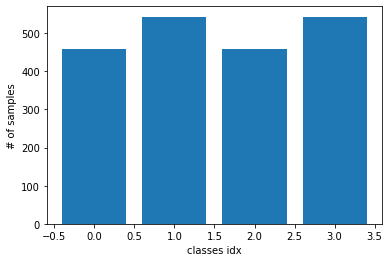

In [21]:
import matplotlib.pyplot as plt
index = np.arange(len(nb_files_per_class))
_= plt.bar(index, nb_files_per_class)
_= plt.ylabel('# of samples')
_= plt.xlabel('classes idx')

# **[2] train!**

In [22]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from models import ModelLoader
from data import CNN3DDataLoader
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import time
print(tf.__version__)

np.random.seed(4)

2.8.2


### Training parameters

In [23]:
n_epochs = 10 # 50
batch_size = 4

with open('data_extracted/train.csv', 'r') as train:
    train_files = csv.reader(train)
    cnt_train = 0
    for line in train_files:
        cnt_train += 1
    
with open('data_extracted/validation.csv', 'r') as validation:
    validation_files = csv.reader(validation)
    cnt_validation = 0
    for line in validation_files:
        cnt_validation += 1
    
print("# of training samples:", cnt_train)
print("# of validation samples:", cnt_validation)

# of training samples: 1400
# of validation samples: 602


### Data parameters

In [24]:
# specify labels to be trained
#labels_want = ['A004', 'A005', 'A011', 'A016', 'A020', 'A027', 'A031', 'A039', 'A048', 'A052', 'A054', 'A055']

# or "None" for all labels
labels_want = None

In [25]:
data_dir = './data_extracted/'
seq_length = 100
samples_train_per_class = None
samples_val_per_class = None

if labels_want == None:
    n_classes = 12
else:
    n_classes = len(labels_want)

if samples_train_per_class == None:
    n_videos = {'train': cnt_train, 'validation': cnt_validation}
else:
    n_videos = {'train': samples_train_per_class * n_classes, 'validation': samples_val_per_class * n_classes}


image_size=(128, 128)

In [26]:
if labels_want == None:
    print(n_classes)
else:
    print(len(labels_want))
print(n_videos['train'])
print(n_videos['validation'])

12
1400
602


In [27]:
if samples_train_per_class == None:
    steps_per_epoch = cnt_train // batch_size
    validation_steps = cnt_validation // batch_size
else:
    steps_per_epoch = samples_train_per_class * n_classes // batch_size
    validation_steps = samples_val_per_class * n_classes // batch_size    

print(steps_per_epoch)
print(validation_steps)

model_name = 'small_c3d'
to_Train = True# False

350
150


### Data load

In [28]:
outDir = './output/{}_CL{}_train{}_val{}/'.format(model_name, n_classes, n_videos['train'], n_videos['validation'])
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [29]:
data = CNN3DDataLoader(data_dir, seq_length=seq_length, n_videos=n_videos, labels = labels_want)
train_gen = data.sequence_generator('train', batch_size, image_size)
validation_gen = data.sequence_generator('validation', batch_size, image_size)

### Training

In [30]:
lr=0.0001
#optimizer = keras.optimizers.Adadelta()
#optimizer = Adam(lr=lr)
optimizer = RMSprop(lr=lr, rho=0.9, epsilon=1e-8)
ml = ModelLoader(data.n_labels, data.seq_length, model_name, image_size=image_size, optimizer = optimizer)
model = ml.model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Loading Small C3D model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 100, 128, 128, 32  2624      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 100, 64, 64, 32)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 100, 64, 64, 64)   55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 50, 32, 32, 64)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 50, 32, 32, 128)   221312    
                                

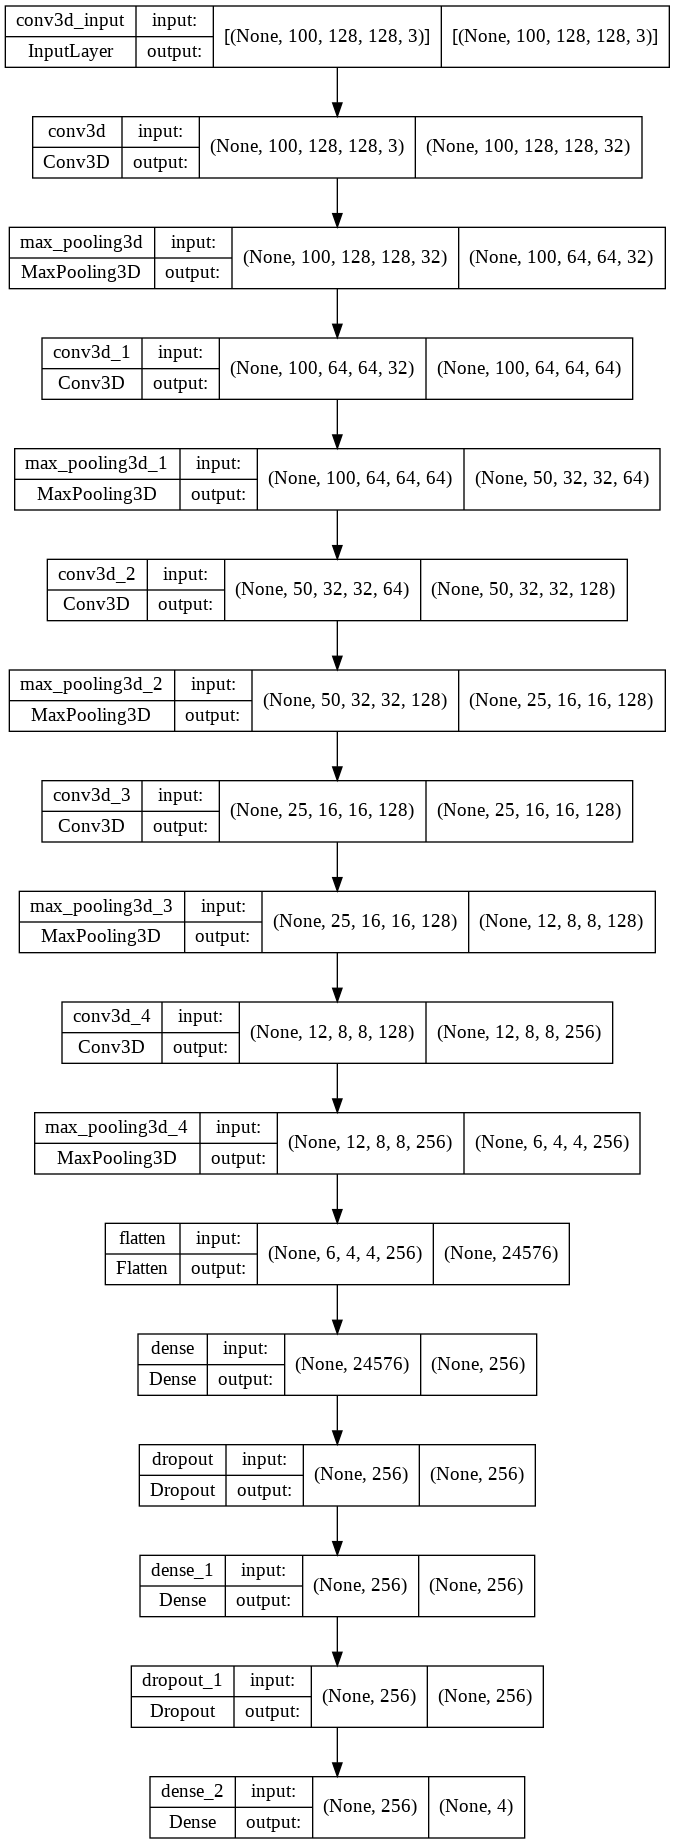

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=outDir+'model_{}.png'.format(model_name), show_shapes=True)
from IPython.display import Image
Image(outDir+'model_{}.png'.format(model_name))

In [32]:
fn_model = outDir + 'model_{}.h5'.format(model_name)
print(fn_model)

./output/small_c3d_CL12_train1400_val602/model_small_c3d.h5


In [33]:
if not to_Train:
    if not os.path.isfile(fn_model):
        to_Train = True
        print('Model file {} not exists !!'.format(fn_model))
        print('Setting to_Train --> {}'.format(to_Train))

    else:
        print('Model file Okay : {}  !!'.format(fn_model))

In [34]:
checkpoint = ModelCheckpoint(outDir + 'ep{epoch:03d}_val_acc{val_acc:.3f}.h5', monitor='val_accuracy', save_weights_only=False, save_best_only=True, save_freq=1)#, period=1

In [35]:
if to_Train:
    history = model.fit_generator(
        generator=train_gen,
        steps_per_epoch=steps_per_epoch,
        #sample_per_epoch= 16,
        epochs=n_epochs,
        verbose=1,
        validation_data=validation_gen,
        validation_steps=validation_steps#,
        #callbacks=[checkpoint]
    )
    model.save(fn_model)
    print("Saved the trained model {}.. okay".format(fn_model))
else:
    model = load_model(fn_model)
    print('Loaded a model {}.. okay'.format(fn_model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
350/350 [==============================] - 1228s 3s/step - loss: 0.7411 - accuracy: 0.5764 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7751 - val_accuracy: 0.5217 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
350/350 [==============================] - 1171s 3s/step - loss: 0.5698 - accuracy: 0.7129 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7816 - val_accuracy: 0.5350 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
350/350 [==============================] - 1168s 3s/step - loss: 0.4931 - accuracy: 0.7743 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1706 - val_accuracy: 0.5517 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
350/350 [==============================] - 1162s 3s/step - loss: 0.4024 - accuracy: 0.8371 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.5027 - val_accuracy: 0.5450 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/10
350/350 [==============================] - 1143s 3s/step - loss: 0.3645 - accuracy: 0.8650 - top_k_ca

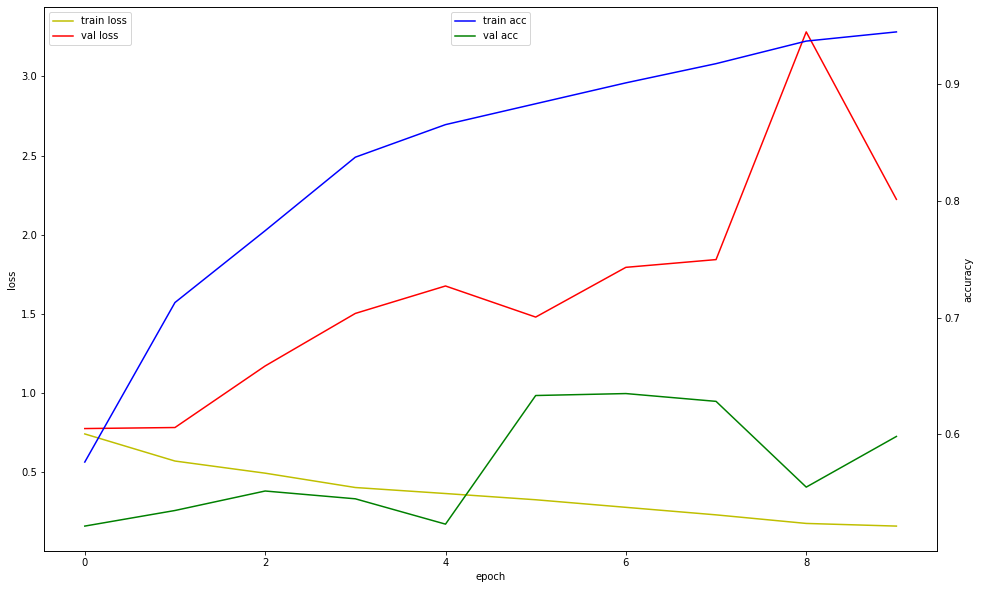

In [36]:
if to_Train:
    fig, loss_ax = plt.subplots(figsize=(16,10))
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper center')
    plt.show()

### Validation

In [37]:
model_name = outDir + 'model_small_c3d.h5'
print(model_name)
model = load_model(model_name)

./output/small_c3d_CL12_train1400_val602/model_small_c3d.h5


In [38]:
v2 = model.evaluate_generator(generator=validation_gen, steps=validation_steps, verbose=1)
print(v2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


150/150 [==============================] - 332s 2s/step - loss: 3.0400 - accuracy: 0.5767 - top_k_categorical_accuracy: 1.0000
[3.0400195121765137, 0.5766666531562805, 1.0]


In [40]:
eval_acc2 = v2[1]
print(eval_acc2)

0.5766666531562805


# **[3] Validation Only**

### Load trained model

In [45]:
np.random.seed(4)

data_dir = './data_extracted/'
seq_length = 100
batch_size = 4
image_size = (128, 128)

data = CNN3DDataLoader(data_dir, seq_length=seq_length, n_videos={'train': None, 'validation': None}, labels=None)
train_gen = data.sequence_generator('train', batch_size, image_size)
validation_gen = data.sequence_generator('validation', batch_size, image_size)



#model_name = 'model_small_c3d.h5'
model_name = './output/small_c3d_CL12_train416_val180/model_small_c3d.h5'
print(model_name)
# model = load_model(model_name)

./output/small_c3d_CL12_train416_val180/model_small_c3d.h5


### Prediction

In [46]:
result = model.evaluate_generator(generator=validation_gen, steps=45, verbose=1)
accuracy = result[1]
print("Validation accuracy:", accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


45/45 [==============================] - 100s 2s/step - loss: 2.7151 - accuracy: 0.5389 - top_k_categorical_accuracy: 1.0000
Validation accuracy: 0.5388888716697693
